# Aim

Note: Since submission 2 I have updated my analysis as I have found a more useful one.

My aim is to demonstrate the progress over time of any one rider.  Are they getting faster or slower?  

# Details

Complicating this analysis is the fact that each race is on a different track and under different conditions, meaning you can't direclty compare between races.  After trying a number of ways to measure relative performance, I have settled on the following analysis as providing the most useful data

# Relative Performance

For each rider, in each race, their average lap time is compared to the fastest lap time of the day.  The fastest lap time of the day is taken as a relatively reliable measure of the track's difficulty and the average lap time is a perfect measure of that rider's performance on that day.

By this measure, the closer your average lap time is to the fastest lap of the day, the better your performance.

# Comparing to self and comparing to "absolute"

Our main goal is to see if a riders relative performance improves over time.

As a secondary goal, we can show the "absolute" level of performance due to a "quirk" of the data we have discovered.

In [17]:
import pandas as pd
import numpy as np


# Loading data

Since we are comparing many races over many years, we need to use data in different forms.  We write two functions:
  * one will read in data from Western Sydney MTB club tables
  * one will read in data from the Hunter MTB club tables

Each require a custom set of clearning and filtering operations to get the dataframes we want.

Each returns a datframe with a standard set of columns to be used in the analysis:
  * Each lap time (up to 5 laps) as a timedelta
  * The rider name
  * The minimum lap time registered by any rider on that day as a timedelta
  * The average lap time for that rider on that day as a timedelta
  * The race id
  * The race date

In [18]:
def load_wsmtb(file, id, datestring):
    wsmtb = pd.read_csv(file, skiprows=2)[["Name","Lap1", "Lap2", "Lap3", "Lap4", "Lap5"]]
    only_riders = wsmtb.index.notnull()
    wsmtb = wsmtb[only_riders]
    # filter junk rows
    wsmtb = wsmtb[wsmtb["Lap1"] != "Lap1"]
    # kill centiseconds
    wsmtb = wsmtb.replace("^(.*\d),\d$", "\\1", regex=True)
    # to timedelta and rename
    wsmtb["lap1"] = pd.to_timedelta(wsmtb["Lap1"])
    wsmtb["lap2"] = pd.to_timedelta(wsmtb["Lap2"])
    wsmtb["lap3"] = pd.to_timedelta(wsmtb["Lap3"])
    wsmtb["lap4"] = pd.to_timedelta(wsmtb["Lap4"])
    wsmtb["lap5"] = pd.to_timedelta(wsmtb["Lap5"])
    wsmtb["name"] = wsmtb["Name"]
    wsmtb = wsmtb[["name","lap1", "lap2", "lap3", "lap4", "lap5"]]
    # exclude kids laps
    wsmtb = wsmtb[wsmtb["lap1"] > pd.Timedelta(11, "minutes")]
    wsmtb["avglap"] = wsmtb[["lap1", "lap2", "lap3", "lap4", "lap5"]].mean(axis=1)
    wsmtb["minlap"] = wsmtb[["lap1", "lap2", "lap3", "lap4", "lap5"]].min().min()
    wsmtb["id"] = id
    wsmtb["date"] = pd.to_datetime(datestring, infer_datetime_format=True)
    return wsmtb
wsmtb_2022_xc3 = load_wsmtb('data/wsmtb/2022-XC-Round-3-Results.csv', "2022 xc1", "2022-05-22")
wsmtb_2018_champs = load_wsmtb("data/wsmtb/2018-XC-Club-Champs.csv", "2018 cmp", "25/11/2018")
wsmtb_2018_xc1 = load_wsmtb("data/wsmtb/2018-XC-Round-1-Results.csv", "2018 xc1", "18/03/2018")
wsmtb_2018_xc2 = load_wsmtb("data/wsmtb/2018-XC-Round-2-Results.csv", "2018 xc2", "08/04/2018")
wsmtb_2018_xc3 = load_wsmtb("data/wsmtb/2018-XC-Round-3-Results.csv", "2018 xc3", "20/05/2018")
wsmtb_2018_xc4 = load_wsmtb("data/wsmtb/2018-XC-Round-4-Results.csv", "2018 xc4", "08/07/2018")
wsmtb_2018_xc5 = load_wsmtb("data/wsmtb/2018-XC-Round-5-Results.csv", "2018 xc5", "19/08/2018")
wsmtb_2018_xc6 = load_wsmtb("data/wsmtb/2018-XC-Round-6-Results.csv", "2018 xc6", "28/10/2018")
wsmtb_2018_xc3[wsmtb_2018_xc3['name'] == "Matthew Roberts"]


,name,lap1,lap2,lap3,lap4,lap5,avglap,minlap,id,date
41,Matthew Roberts,0 days 00:21:25,0 days 00:21:43,0 days 00:21:47,0 days 00:21:27,NaT,0 days 00:21:35.500000,0 days 00:17:10,2018 xc3,2018-05-20


In [19]:
def load_hmtba():
    a_grade = pd.read_csv('data/hmtba/2022-XC-Round-3-AGrade.csv')[["name","lap1", "lap2", "lap3", "lap4", "lap5"]]
    b_grade = pd.read_csv('data/hmtba/2022-XC-Round-3-BGrade.csv')[["name","lap1", "lap2", "lap3", "lap4", "lap5"]]
    c_grade = pd.read_csv('data/hmtba/2022-XC-Round-3-CGrade.csv')[["name","lap1", "lap2", "lap3", "lap4", "lap5"]]
    d_grade = pd.read_csv('data/hmtba/2022-XC-Round-3-DGrade.csv')[["name","lap1", "lap2", "lap3", "lap4", "lap5"]]
    hmtba_xc3 = pd.concat([a_grade, b_grade, c_grade, d_grade])
    hmtba_xc3 = hmtba_xc3.replace('^\s*$', np.nan, regex=True)
    hmtba_xc3["lap1"] = pd.to_timedelta(hmtba_xc3["lap1"])
    hmtba_xc3["lap2"] = pd.to_timedelta(hmtba_xc3["lap2"])
    hmtba_xc3["lap3"] = pd.to_timedelta(hmtba_xc3["lap3"])
    hmtba_xc3["lap4"] = pd.to_timedelta(hmtba_xc3["lap4"])
    hmtba_xc3["lap5"] = pd.to_timedelta(hmtba_xc3["lap5"])
    hmtba_xc3["avglap"] = hmtba_xc3[["lap1", "lap2", "lap3", "lap4", "lap5"]].mean(axis=1)
    hmtba_xc3["minlap"] = hmtba_xc3[["lap1", "lap2", "lap3", "lap4", "lap5"]].min().min()
    hmtba_xc3["id"] = "2022 xc2"
    hmtba_xc3["date"] = pd.to_datetime("2022-06-19")
    return hmtba_xc3

hmtba_xc3 = load_hmtba()

We concatenate all these files and check the data looks reasonable.

In [20]:
races = pd.concat([wsmtb_2018_xc1, wsmtb_2018_xc2, wsmtb_2018_xc3, wsmtb_2018_xc4, wsmtb_2018_xc5, wsmtb_2018_xc6, wsmtb_2018_champs, wsmtb_2022_xc3, hmtba_xc3])
races


,name,lap1,lap2,lap3,lap4,lap5,avglap,minlap,id,date
1,Luke Brame,0 days 00:13:12,0 days 00:13:08,0 days 00:14:03,0 days 00:13:07,0 days 00:13:01,0 days 00:13:18.200000,0 days 00:10:41,2018 xc1,2018-03-18
2,Matthew Dinham,0 days 00:13:12,0 days 00:13:07,0 days 00:14:03,0 days 00:13:07,0 days 00:13:02,0 days 00:13:18.200000,0 days 00:10:41,2018 xc1,2018-03-18
3,Owen Gordon,0 days 00:13:32,0 days 00:13:30,0 days 00:13:55,0 days 00:13:31,0 days 00:13:32,0 days 00:13:36,0 days 00:10:41,2018 xc1,2018-03-18
4,David Ludenia,0 days 00:13:43,0 days 00:13:43,0 days 00:14:23,0 days 00:13:43,0 days 00:14:09,0 days 00:13:56.200000,0 days 00:10:41,2018 xc1,2018-03-18
5,Brian Price,0 days 00:13:48,0 days 00:14:07,0 days 00:14:47,0 days 00:14:12,0 days 00:14:15,0 days 00:14:13.800000,0 days 00:10:41,2018 xc1,2018-03-18
...,...,...,...,...,...,...,...,...,...,...
3,Peter Riccio,0 days 00:22:48.100000,0 days 00:22:49.100000,NaT,NaT,NaT,0 days 00:22:48.600000,0 days 00:16:23.500000,2022 xc2,2022-06-19
4,Simon McElduff,0 days 00:22:36.500000,0 days 00:23:45.100000,NaT,NaT,NaT,0 days 00:23:10.800000,0 days 00:16:23.500000,2022 xc2,2022-06-19
5,Hamish Rae,0 days 00:23:54.600000,0 days 00:26:33.700000,NaT,NaT,NaT,0 days 00:25:14.150000,0 days 00:16:23.500000,2022 xc2,2022-06-19
6,Peter Woodward,0 days 00:26:57.700000,NaT,NaT,NaT,NaT,0 days 00:26:57.700000,0 days 00:16:23.500000,2022 xc2,2022-06-19


The dataframe shown here contains every performance by every rider in the dataset.  We expect multiple rows for riders who entered more than one race.

We now calculate a "relativelap" column for every performance - this is our measure of how well the rider performed on the day.  Lower relative lap is a better performance.

By plotting all relative performances we can see an interesting trend.

In [21]:

races["relativelap"] = races["avglap"]/races["minlap"]


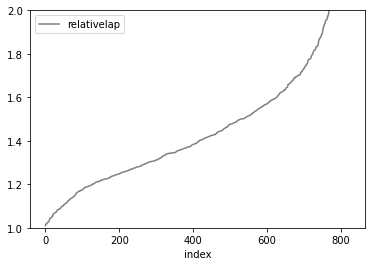

In [22]:
sorted_racers = races.sort_values("relativelap")[["name","relativelap", "id", "date"]].reset_index(drop=True)
plt = sorted_racers.reset_index().plot(kind="line", color="Grey", x="index", y="relativelap", ylim=(1,2))


We see two inflection points!  These represent some features of the cohort we are displaying.  By looking over the data, I can see the inflection around y value of 1.2 represents the transition from elite riders to "weekend warriors" (people who take their sport seriously, but have day-jobs). The inflection point around y of 1.6 is the transition from weekend warriors to recreational riders.

To validate this hypothesis, I plot the results for two riders who fit into the two categories:
  * Matt Roberts (a weekend warrior) in orange
  * Steven Tomczyk (an elite rider on a good day) in green.

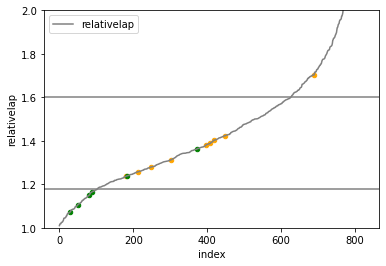

In [23]:

sorted_racers = races.sort_values("relativelap")[["name","relativelap", "id", "date"]].reset_index(drop=True)
plt = sorted_racers.reset_index().plot(kind="line", color="Grey", x="index", y="relativelap", ylim=(1,2))
just_matt = (sorted_racers["name"] == "Matthew Roberts") | (sorted_racers["name"] == "MATTHEW ROBERTS")
sorted_racers[just_matt].reset_index().plot(kind="scatter", color="Orange", x = "index", y = "relativelap", ax=plt)
sorted_racers[sorted_racers["name"] == "Stephen Tomczyk"].reset_index().plot(kind="scatter", color="Green", x = "index", y = "relativelap", ax=plt)
plt.axhline(y=1.18, color="Grey", linestyle="-")
plt.axhline(y=1.6, color="Grey", linestyle="-")


Out of interest, I do a box plot which shows similar boundaries and all the outliers at the high-end (as expected for the hypothesis)

<AxesSubplot:>

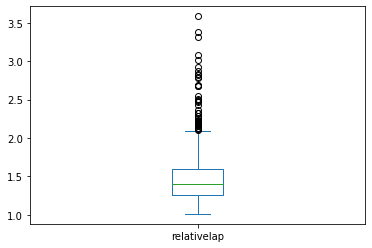

In [24]:
sorted_racers["relativelap"].plot(kind="box")

Finally, we address the issue of rider improvement.  Racing typically happens in 1-year "seasons" so we are interested to see if a rider improves over the season.  Here I have plotted the 2018 and 2022 seasons for myself (Matt Roberts) and included the weekend warrior boundaries.

The data shows that 2018 was a season where I steadily improved over the year form a very low base and 2022 is heading in the same direction.

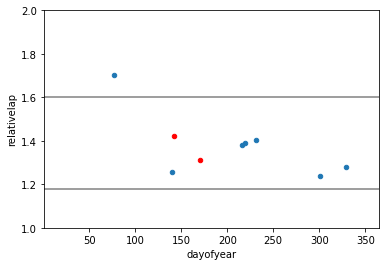

In [25]:
just_2018 = sorted_racers["date"].dt.year == 2018
just_2022 = sorted_racers["date"].dt.year == 2022
sorted_racers["dayofyear"] = sorted_racers["date"].dt.dayofyear
ax = sorted_racers[just_matt & just_2018].plot(kind="scatter", x = "dayofyear", y="relativelap", ylim=(1,2), xlim=(1,365))
sorted_racers[just_matt & just_2022].plot(kind="scatter", color="Red", x = "dayofyear", y="relativelap", ylim=(1,2), xlim=(1,365), ax= ax)
ax.axhline(y=1.18, color="Grey", linestyle="-")
ax.axhline(y=1.6, color="Grey", linestyle="-")

I have done the same analysis for an elite rider.  Their first race of the year was out of character and then they performed well every race after that.  They improved over the year as well.

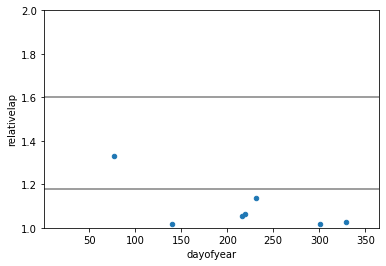

In [26]:
just_other = (sorted_racers["name"] == "Brian Price")
ax = sorted_racers[just_other & just_2018].plot(kind="scatter", x = "dayofyear", y="relativelap", ylim=(1,2), xlim=(1,365))
sorted_racers[just_other & just_2022].plot(kind="scatter", color="Red", x = "dayofyear", y="relativelap", ylim=(1,2), xlim=(1,365), ax= ax)
ax.axhline(y=1.18, color="Grey", linestyle="-")
ax.axhline(y=1.6, color="Grey", linestyle="-")

# 2018 day 145-ish

There is an outlier in both performance plots on that day, we could investigate that if we wanted.....